# Izrada modela i evaluacija

---

## 1. Uvoz knjižnica i postavke

In [27]:
# Knjižnice
import os
import random
import shutil
from pathlib import Path
from timeit import default_timer as timer
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset, Dataset
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torchinfo import summary

from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

---

## 2. Priprema skupa podataka

In [29]:
dataset_path  = "./datasets/dataset_clean/dataset_clean.csv"
dataset_images_path = Path("./datasets/dataset_clean/images/")

dataset = pd.read_csv(dataset_path)

In [30]:
class ProductDataset(Dataset):
    def __init__(self, dataframe, transform=None, classes=None):
        self.data = dataframe
        self.transform = transform
        self.classes = classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']
        label = row['category_encoded']

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image not found: {image_path}")
            raise

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
dataset['image_path'] = dataset['image_path'].apply(lambda x: dataset_images_path / Path(x).name)

categories = sorted(dataset['category'].unique())

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [32]:
train_data = dataset.sample(frac=0.8, random_state=42)
test_data = dataset.drop(train_data.index)

train_dataset = ProductDataset(train_data, transform=train_transform, classes=categories)
test_dataset = ProductDataset(test_data, transform=test_transform, classes=categories)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

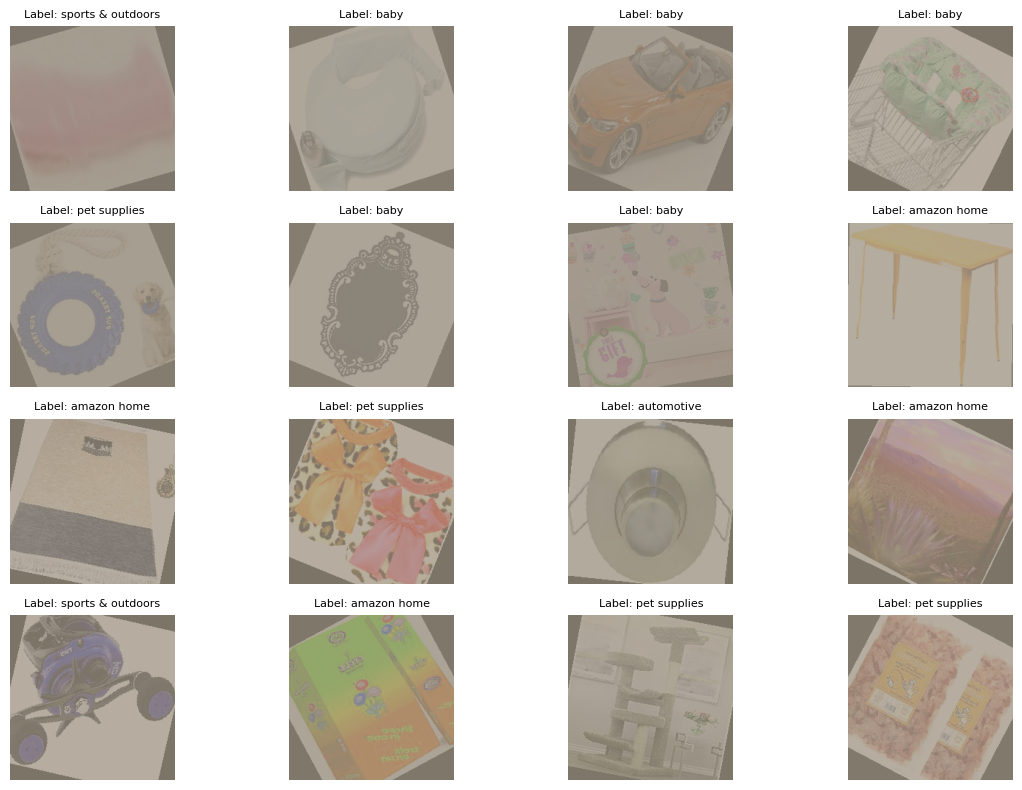

In [33]:
def show_images_with_labels(data_loader, classes, num_images=16):
    images, labels = next(iter(data_loader))

    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images = images * std + mean

    images = images.permute(0, 2, 3, 1).clamp(0, 1)

    plt.figure(figsize=(12, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {classes[labels[i].item()]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images_with_labels(train_loader, train_dataset.classes)

---

## 3. Definiranje i treniranje modela

In [34]:
num_classes = len(categories)

def create_resnet50(num_classes: int):
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights).to(device)

    for params in model.parameters():
        params.requires_grad = False

    model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=num_classes, bias=True))
    return model, transforms

resnet50, _ = create_resnet50(num_classes=num_classes)

In [35]:
summary(resnet50, input_size=(1, 3, 224, 224), col_names=['input_size','output_size','num_params','trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 5]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [36]:
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y_pred)

    avg_loss = train_loss / len(dataloader)
    avg_acc = train_acc / len(dataloader)
    return avg_loss, avg_acc

def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, device: torch.device) -> Tuple[float, float, List[int], List[int]]:

    model.eval()
    test_loss, test_acc = 0, 0
    all_y_true, all_y_pred = [], []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y_pred)

            all_y_true.extend(y.cpu().tolist())
            all_y_pred.extend(y_pred.argmax(dim=1).cpu().tolist())

    avg_loss = test_loss / len(dataloader)
    avg_acc = test_acc / len(dataloader)

    return avg_loss, avg_acc, all_y_true, all_y_pred

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module, epochs: int, device: torch.device) -> Tuple[Dict[str, List], List[int], List[int]]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0.0
    best_test_y_true, best_test_y_pred = [], []

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc, test_y_true, test_y_pred = test_step(model, test_dataloader, loss_fn, device)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_y_true = test_y_true
            best_test_y_pred = test_y_pred

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

    return results, best_test_y_true, best_test_y_pred

In [37]:
for param in resnet50.layer4.parameters():
    param.requires_grad = True

loss = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=resnet50.parameters(), lr=0.001, weight_decay=1e-4)

resnet50_results, y_true, y_pred = train(model=resnet50, train_dataloader=train_loader, test_dataloader=test_loader, optimizer=optimizer, loss_fn=loss, device=device, epochs=10)

Epoch 1: train_loss=1.0841, train_acc=0.6456, test_loss=0.9758, test_acc=0.7052
Epoch 2: train_loss=0.9859, train_acc=0.7006, test_loss=0.9586, test_acc=0.7185
Epoch 3: train_loss=0.9490, train_acc=0.7231, test_loss=1.0189, test_acc=0.6884
Epoch 4: train_loss=0.9199, train_acc=0.7369, test_loss=0.9849, test_acc=0.7085
Epoch 5: train_loss=0.9001, train_acc=0.7484, test_loss=0.9878, test_acc=0.7090
Epoch 6: train_loss=0.8877, train_acc=0.7576, test_loss=0.9554, test_acc=0.7268
Epoch 7: train_loss=0.8723, train_acc=0.7641, test_loss=0.9543, test_acc=0.7286
Epoch 8: train_loss=0.8560, train_acc=0.7739, test_loss=0.9450, test_acc=0.7335
Epoch 9: train_loss=0.8449, train_acc=0.7778, test_loss=0.9710, test_acc=0.7164
Epoch 10: train_loss=0.8317, train_acc=0.7868, test_loss=1.0057, test_acc=0.7058


In [38]:
torch.save(obj=resnet50.state_dict(), f="./models/model_classification_images.pth")

---

## 4. Evaluacija i vizualizacija modela

In [39]:
resnet50,_ = create_resnet50(num_classes=num_classes)
resnet50.load_state_dict(torch.load(f='./models/model_classification_images.pth'))

C:\Users\mateo\AppData\Local\Temp\ipykernel_18604\2584997081.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50.load_state_dict(torch.load(f='./models/model_classi

<All keys matched successfully>

Accuracy: 0.734
Precision: 0.7376964596577945
Recall: 0.734
F1 score: 0.7323086950515398


Classification report:

                   precision    recall  f1-score   support

      amazon home       0.66      0.74      0.70      2042
       automotive       0.73      0.77      0.75      1948
             baby       0.80      0.89      0.84      2003
     pet supplies       0.83      0.65      0.73      2008
sports & outdoors       0.68      0.62      0.65      1999

         accuracy                           0.73     10000
        macro avg       0.74      0.73      0.73     10000
     weighted avg       0.74      0.73      0.73     10000





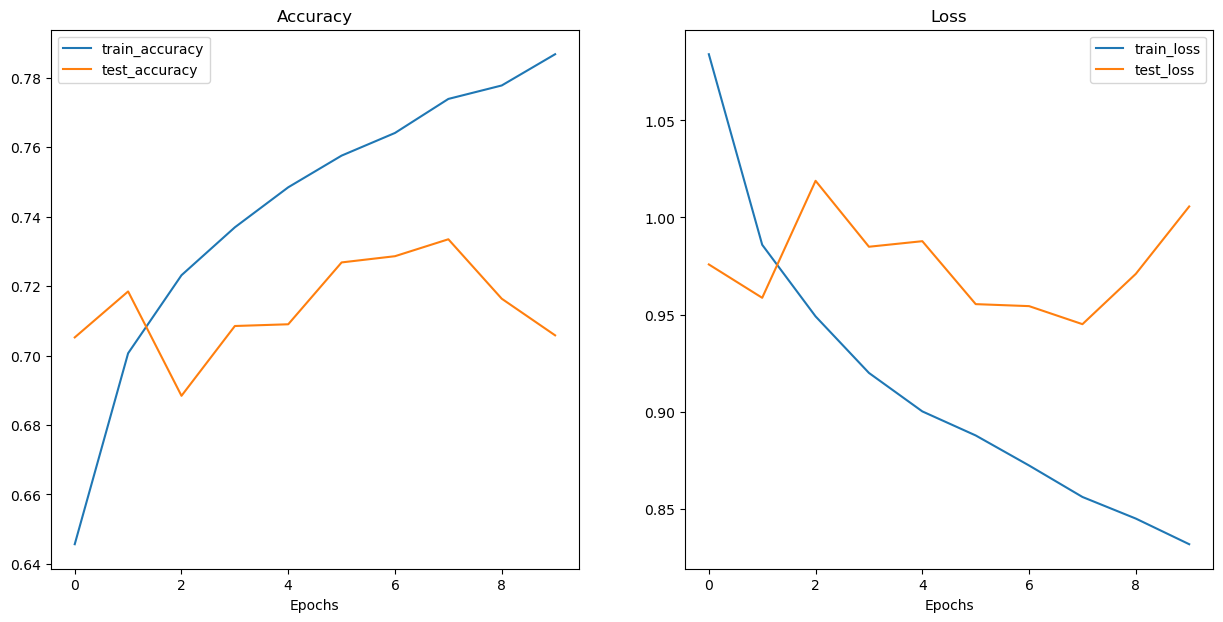

In [40]:
# 8. Evaluate model
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
print(f"F1 score: {f1_score(y_true, y_pred, average='weighted')}\n\n")
print(f"Classification report:\n\n{classification_report(y_true, y_pred, target_names=test_dataset.classes)}\n\n")

# 8.1. Display accuracy and loss
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(range(len(resnet50_results["train_loss"])), resnet50_results["train_acc"], label="train_accuracy")
plt.plot(range(len(resnet50_results["train_loss"])), resnet50_results["test_acc"], label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(resnet50_results["train_loss"])), resnet50_results["train_loss"], label="train_loss")
plt.plot(range(len(resnet50_results["train_loss"])),  resnet50_results["test_loss"], label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

---

## 5. Testiranje modela na novim proizvodima


Accuracy on selected images: 75.00%.




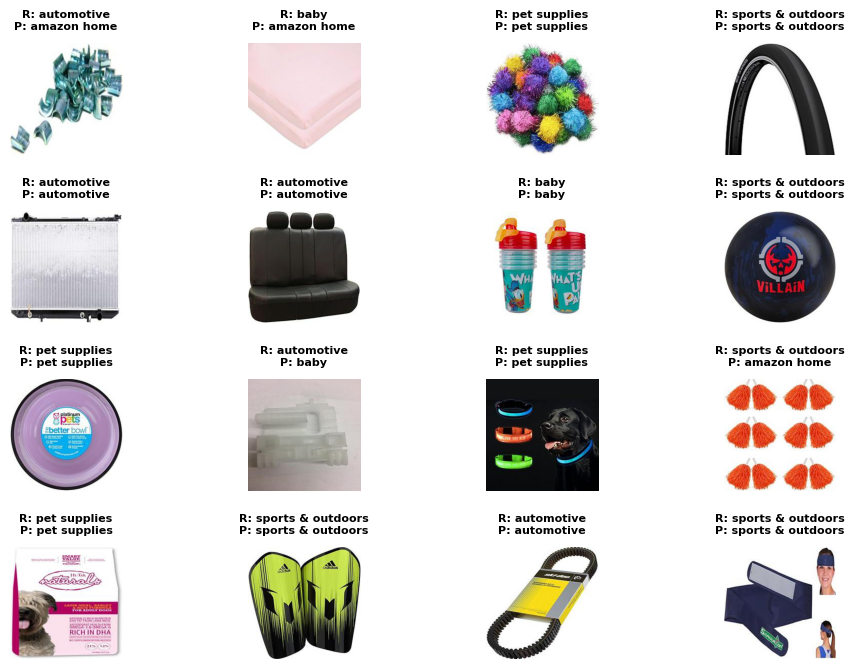

In [46]:
def pred_and_plot_image(ax, model: torch.nn.Module, image_path: str, true_label: int, class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        image_transform = test_transform, device: torch.device=device):

    img = Image.open(image_path).convert("RGB")
    model.to(device)

    model.eval()

    with torch.inference_mode():
        transformed_image = image_transform(img).unsqueeze(dim=0).to(device)
        target_image_pred = model(transformed_image)

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1).item()

    # Display image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"R: {class_names[true_label]}\nP: {class_names[target_image_pred_label]}",
                 fontsize=8, fontweight='bold', pad=10)

    return true_label == target_image_pred_label

num_classes_to_plot = 16

selected_test_samples = test_data.sample(n=num_classes_to_plot, random_state=42)

fig, axs = plt.subplots(4, 4, figsize=(12, 8))
axs = axs.flatten()
plt.subplots_adjust(wspace=0.1, hspace=0.5)

correct_predictions = 0

for i, (_, row) in enumerate(selected_test_samples.iterrows()):
    image_path = row['image_path']
    true_label = row['category_encoded']
    
    is_correct = pred_and_plot_image(
        axs[i], model=resnet50, image_path=image_path, true_label=true_label,
        class_names=test_dataset.classes, image_size=(224, 224)
    )
    
    if is_correct:
        correct_predictions += 1

accuracy = correct_predictions / num_classes_to_plot * 100
print(f"\nAccuracy on selected images: {accuracy:.2f}%.\n\n")
plt.show()